In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
import os
import sys
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

In [3]:
def perh():
    return (cosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [4]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) * perh()

In [5]:
def Gaussian_draw(dx, size=None):
    if isinstance(dx, u.Quantity):
        return np.random.normal(loc=0.0, scale=dx.value, size=size) * dx.unit
    else:
        return np.random.normal(loc=0.0, scale=dx, size=size)

#### compare Gal x DM with and without redshift error

In [6]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)

Take a $\sigma_z$ from the SPHEREx public product repo (assuming worst redshift uncertainty per bin), load in the corresponding galaxies, and perturb each one along the LOS (take the LOS to be along the $z$ axis):

In [7]:
sigma_z = 0.01
gal_pos = sim.subhalo_pos()[sim.gal_idx('ELG', 'SPHEREx', sigma_z=sigma_z, verbose=True)]
# center the positions
gal_pos -= np.mean(gal_pos)
print(gal_pos.shape, gal_pos.unit)

ELG number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
(7224, 3) Mpc / littleh


In [8]:
dx = get_dx(redshift, sigma_z)
dx

<Quantity 34.14988849 Mpc / littleh>

In [9]:
gal_pos_perturbed = np.copy(gal_pos)
gal_pos_perturbed[:,2] += Gaussian_draw(dx, size=len(gal_pos))

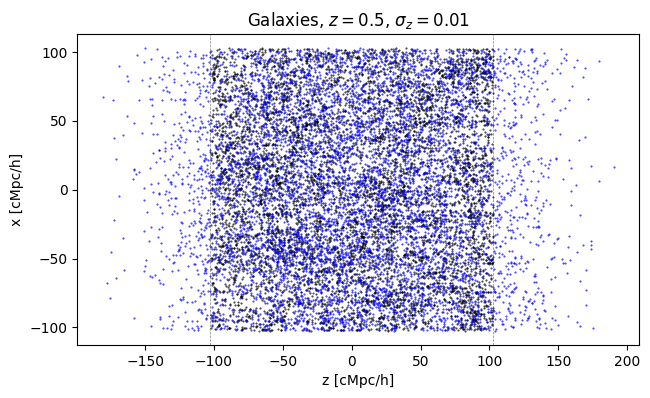

In [10]:
# compare positions
fig, ax = plt.subplots(figsize=(7,4))

kwargs = dict(ls='None', marker='.', ms=1, alpha=0.8)
ax.plot(gal_pos[:,2].value, gal_pos[:,0].value, color='k', **kwargs)
ax.plot(gal_pos_perturbed[:,2].value, gal_pos_perturbed[:,0].value, color='b', **kwargs)
ax.axvline(-(sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline((sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

#### cross-correlations

In [11]:
# load dm positions and subsample
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100)

In [12]:
# params
randmult = 1
rmin = 1.
rmax = 75.
nbins = 20
nthreads = 12

In [13]:
%%time
# unperturbed
ravg, galxDM_true = corrfunc_ls.compute_3D_ls_cross(dm_pos.value, gal_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, boxsize=sim.boxsize.value)
# perturbed
ravg, galxDM_err = corrfunc_ls.compute_3D_ls_cross(dm_pos.value, gal_pos_perturbed.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, boxsize=sim.boxsize.value)

CPU times: user 33.2 s, sys: 180 ms, total: 33.4 s
Wall time: 2.97 s


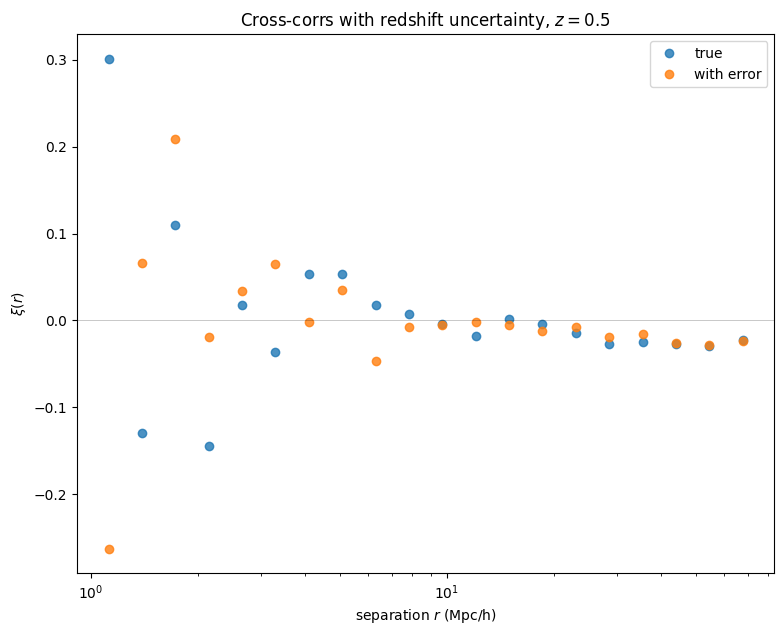

In [14]:
fig, ax = plt.subplots(figsize=(9,7))

kwargs = dict(alpha=0.8, ls='None', marker='o', ms=6)

ax.plot(ravg, galxDM_true, label='true', **kwargs)
ax.plot(ravg, galxDM_err, label='with error', **kwargs)

ax.axhline(0, color='k', ls='-', alpha=0.3, lw=0.5)

# ax.set_ylim(-2,None)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(r'Cross-corrs with redshift uncertainty, '+f'$z=${sim.redshift}')
ax.legend()

Text(0.5, 1.0, 'GalxDM_err / GalxDM_true, $z=$0.5')

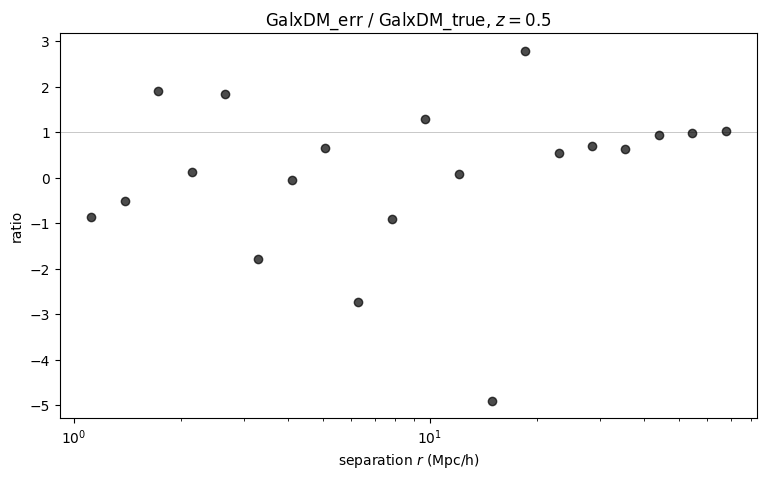

In [21]:
# error
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(ravg, galxDM_err/galxDM_true, alpha=0.7, color='k', ls='None', marker='o')

ax.axhline(1., color='k', ls='-', alpha=0.3, lw=0.5)

# ax.set_ylim(-2,None)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'ratio')
ax.set_title(r'GalxDM_err / GalxDM_true, '+f'$z=${sim.redshift}')